In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import yfinance as yf
from yahooquery import Ticker

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Conv1D, MaxPool1D
from sklearn.preprocessing import MinMaxScaler, RobustScaler

%matplotlib inline

from utils import *

In [5]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    seed = 42
   

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [22]:
cnn_predictions_n_errors = pd.DataFrame(
                                        data=None,
                                        index=None,
                                        columns=['1_day', '5_days', '10_days', '1_month', '2_months', '6_months', '1_year']
                                        )

cnn_predictions_n_errors['Dataset'] = ['IXIC', 'IXIC', 'IXIC', 'DJI', 'DJI', 'DJI', 'SPX', 'SPX', 'SPX']
cnn_predictions_n_errors['Metric'] = ['RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE']

cnn_predictions_n_errors.set_index(['Dataset', 'Metric'], inplace=True)

In [23]:
cnn_predictions_n_errors

1_day 5_days 10_days 1_month 2_months 6_months 1_year
Dataset Metric                                                      
IXIC    RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
DJI     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
SPX     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN

In [24]:
START_DATE = '2017-01-01'
END_DATE = '2023-01-01'

nq = yf.download(tickers = "^IXIC",  
                    start=START_DATE, 
                    end=END_DATE)

dji = yf.download(tickers = "^DJI",  
                    start=START_DATE, 
                    end=END_DATE)

spx = yf.download(tickers = "^SPX",  
                    start=START_DATE, 
                    end=END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
merged_df_dict = {
                  'Date': np.array(nq.index), 
                  'IXIC': np.array(nq.Close.values), 
                  'SPX': np.array(spx.Close.values), 
                  'DJI': np.array(dji.Close.values)
                  }

merged_df_index = nq.index

merged_df = pd.DataFrame(data=merged_df_dict, index=merged_df_index, columns=['Date', 'IXIC', 'SPX', 'DJI'])

In [6]:
def create_cnn_for_ts(input_size=50, output_dim=1):
  model_old = models.Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(input_size, 1)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPool1D(pool_size=4),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(output_dim),
  ])

  model_new2 = models.Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_size, 1)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPool1D(pool_size=4),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(output_dim),
  ])

  model_new = models.Sequential([
    Conv1D(filters=8, kernel_size=2, activation='elu', input_shape=(input_size, 1)),
    Conv1D(filters=16, kernel_size=2, activation='elu'),
    Conv1D(filters=32, kernel_size=2, activation='elu'),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(output_dim, activation='relu')
  ])

  return model_old

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [37]:
def cnn_pipe(lookback_horizon, save_dir, model_str, cnn_predictions_n_errors):

  for dataset in set(cnn_predictions_n_errors.index.get_level_values(0)):

    df = merged_df[['Date', dataset]].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)
    
    for pred_horizon, horizon_string in [[1, '1_day'], [5, '5_days'], [10, '10_days'], [30, '1_month']]:
      
      look_back = lookback_horizon
      look_ahead = pred_horizon

      xdat, ydat = create_dataset(
                                  df,
                                  look_back = look_back,
                                  look_ahead = look_ahead
                                  )

      # [batch size, time steps, dimensionality]
      xtrain, ytrain, xvalid, yvalid = prepare_split(
                                                    xdat,
                                                    ydat,
                                                    cutoff = int(len(xdat) * 0.8),
                                                    timesteps = look_back
                                                    )

      xtrain.shape = xtrain.shape[0], xtrain.shape[1]
      xvalid.shape = xvalid.shape[0], xvalid.shape[1]

      model = create_cnn_for_ts(xtrain.shape[1], look_ahead)

      model.compile(optimizer="adam", loss="mae", metrics=["acc"])
      
      model.fit(x=xtrain, y=ytrain,
              validation_data=(xvalid, yvalid),
              epochs=20, steps_per_epoch=400, 
              validation_steps=10, verbose=1,
              callbacks=[early_stop])

     
      
      y_pred = model.predict(xvalid)
      print(f"Prediction {y_pred.shape}")
      print(f"Prediction {yvalid.shape}")
      y_pred = scaler.inverse_transform(y_pred)
      yvalid = scaler.inverse_transform(yvalid)
      
      plt.plot([item[0] for item in yvalid], label="True")
      # plt.plot([item.mean() for item in y_pred], label="Forecast")
      plt.plot([item[0] for item in y_pred], label="Forecast")
      plt.legend()
      plt.savefig(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{dataset}_{horizon_string}.jpg", bbox_inches='tight', dpi=120)
      plt.clf()
      
      cnn_predictions_n_errors = assign_values(cnn_predictions_n_errors,
                                                dataset,
                                                y_pred,
                                                yvalid,
                                                horizon_string)
      
  cnn_predictions_n_errors.to_csv(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{save_dir}_window_errors.csv")

In [38]:
cnn_pipe(20, '20d', 'cnn', cnn_predictions_n_errors)

Epoch 1/20
400/400 [==============================] - 4s 5ms/step - loss: 0.0398 - acc: 8.3333e-04 - val_loss: 0.0460 - val_acc: 0.0034
Epoch 2/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0290 - acc: 8.3333e-04 - val_loss: 0.0423 - val_acc: 0.0034
Epoch 3/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0291 - acc: 8.3333e-04 - val_loss: 0.0430 - val_acc: 0.0034
Epoch 4/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0284 - acc: 8.3333e-04 - val_loss: 0.0577 - val_acc: 0.0034
Epoch 5/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0277 - acc: 8.3333e-04 - val_loss: 0.0817 - val_acc: 0.0034
Epoch 6/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0264 - acc: 8.3333e-04 - val_loss: 0.0421 - val_acc: 0.0034
Epoch 7/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0252 - acc: 8.3333e-04 - val_loss: 0.0352 - val_acc: 0.0034
Epoch 8/20
400/400 [============================

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [32]:
cnn_pipe(50, '50d', 'cnn', cnn_predictions_n_errors)

Epoch 1/20
400/400 [==============================] - 3s 4ms/step - loss: 0.0477 - acc: 8.3333e-04 - val_loss: 0.1060 - val_acc: 0.0034
Epoch 2/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0310 - acc: 0.0017 - val_loss: 0.0736 - val_acc: 0.0034
Epoch 3/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0310 - acc: 0.0000e+00 - val_loss: 0.0392 - val_acc: 0.0034
Epoch 4/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0268 - acc: 8.3333e-04 - val_loss: 0.0355 - val_acc: 0.0034
Epoch 5/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0251 - acc: 8.3333e-04 - val_loss: 0.0368 - val_acc: 0.0034
Epoch 6/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0227 - acc: 8.3333e-04 - val_loss: 0.0321 - val_acc: 0.0034
Epoch 7/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0210 - acc: 8.3333e-04 - val_loss: 0.0353 - val_acc: 0.0034
Epoch 8/20
400/400 [==============================] 

<Figure size 1440x720 with 0 Axes>

In [33]:
cnn_pipe(80, '80d', 'cnn', cnn_predictions_n_errors)

Epoch 1/20
400/400 [==============================] - 3s 4ms/step - loss: 0.0488 - acc: 8.3333e-04 - val_loss: 0.1419 - val_acc: 0.0035
Epoch 2/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0425 - acc: 8.3333e-04 - val_loss: 0.0895 - val_acc: 0.0035
Epoch 3/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0351 - acc: 8.3333e-04 - val_loss: 0.0754 - val_acc: 0.0035
Epoch 4/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0330 - acc: 8.3333e-04 - val_loss: 0.0429 - val_acc: 0.0035
Epoch 5/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0327 - acc: 0.0017 - val_loss: 0.0422 - val_acc: 0.0035
Epoch 6/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0341 - acc: 0.0000e+00 - val_loss: 0.0635 - val_acc: 0.0035
Epoch 7/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0292 - acc: 0.0017 - val_loss: 0.0602 - val_acc: 0.0035
Epoch 8/20
400/400 [==============================] - 1s

<Figure size 1440x720 with 0 Axes>

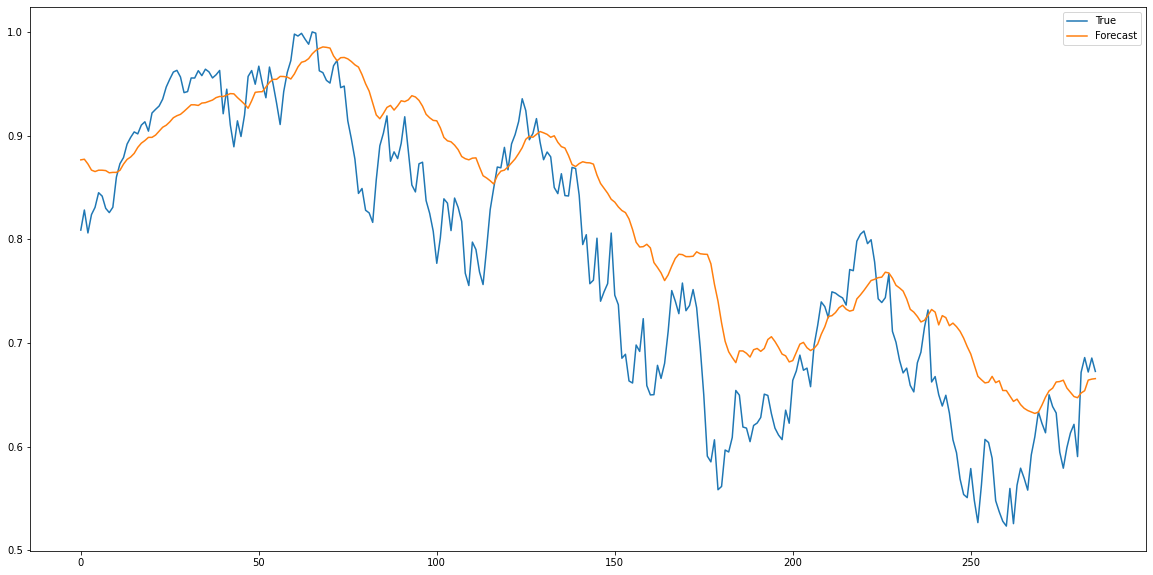

In [182]:
# plt.plot([item.mean() for item in yvalid], label="True")
plt.plot([item[0] for item in yvalid], label="True")
# plt.plot([item.mean() for item in y_pred], label="Forecast")
plt.plot([item[0] for item in y_pred], label="Forecast")
plt.legend()
plt.savefig(f"{CFG.data_path}/foo.jpg", bbox_inches='tight', dpi=120)
plt.show()